In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
data = '/content/gdrive/MyDrive/data'

Mounted at /content/gdrive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from sklearn.metrics import confusion_matrix
import itertools
np.random.seed(2)

from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [4]:
X_train = np.load(data + "/train_pixels.npy")
y_train = np.load(data + "/train_labels.npy")
X_val =   np.load(data + "/eval_pixels.npy")
y_val =   np.load(data + "/eval_labels.npy")
X_test =  np.load(data + "/test_pixels.npy")
y_test =  np.load(data + "/test_labels.npy")

In [5]:
X_train = np.expand_dims(X_train, -1).astype("float32") / 255
X_val = np.expand_dims(X_val, -1).astype("float32") / 255
X_test = np.expand_dims(X_test, -1).astype("float32") / 255

In [6]:
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [7]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
  model.add(MaxPooling2D((2,2))) 
  model.add(Dropout(0.5))

  model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
  model.add(MaxPooling2D((2,2))) 
  model.add(Dropout(0.5))

  model.add(Conv2D(256, (3,3), padding="Same", activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, (5,5), padding="Same", activation='relu'))
  model.add(MaxPooling2D((2,2))) 
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(7, activation='softmax'))
  optimizer = opt.Adam(lr = 0.001)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

### Compile and train the model

In [8]:
start = time.time()
model = define_model()
# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1)

lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size = 100, callbacks=[es,lr_anneal])
print('Elasped Time in minutes:  %.2f' % ((time.time() - start)/60))

Epoch 1/50
288/288 [==============================] - 45s 40ms/step - loss: 2.1552 - accuracy: 0.3186 - val_loss: 1.6674 - val_accuracy: 0.3586
Epoch 2/50
288/288 [==============================] - 10s 36ms/step - loss: 1.3591 - accuracy: 0.4882 - val_loss: 1.0971 - val_accuracy: 0.6060
Epoch 3/50
288/288 [==============================] - 10s 36ms/step - loss: 1.0946 - accuracy: 0.6019 - val_loss: 1.2035 - val_accuracy: 0.5913
Epoch 4/50
288/288 [==============================] - 10s 36ms/step - loss: 0.9830 - accuracy: 0.6443 - val_loss: 0.8578 - val_accuracy: 0.6966
Epoch 5/50
288/288 [==============================] - 10s 36ms/step - loss: 0.9044 - accuracy: 0.6733 - val_loss: 0.8355 - val_accuracy: 0.7083
Epoch 6/50
288/288 [==============================] - 10s 36ms/step - loss: 0.8415 - accuracy: 0.6920 - val_loss: 0.9318 - val_accuracy: 0.6996
Epoch 7/50
288/288 [==============================] - 10s 36ms/step - loss: 0.7874 - accuracy: 0.7117 - val_loss: 0.8993 - val_accuracy:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        2

In [10]:
model.save(data +'/final_cnn_model.h5')
time.sleep(10)

### Evaluate the model

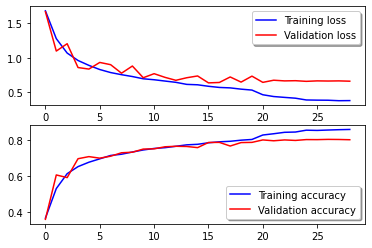

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [12]:
score, acc = model.evaluate(X_val, y_val, verbose=0)
print('validate score: %.3f'% score)
print('validate accuracry: %.3f' % (acc * 100.0))

validate score: 0.660
validate accuracry: 80.245


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

In [14]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

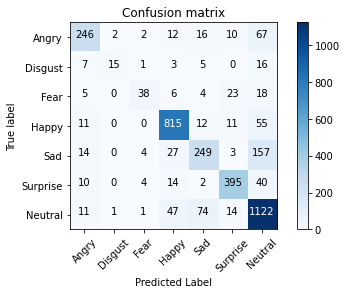

In [15]:
# Predict the values from the validation dataset
y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 

# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix

plot_confusion_matrix(confusion_mtx, classes = emotions)


### Final predictions

In [16]:
save_model = load_model(data+'/final_cnn_model.h5')

In [17]:
start = time.time()
score, acc = save_model.evaluate(X_test, y_test, verbose=0)
print('Test score: %.3f'% score)
print('Test accuracry: %.3f' % (acc * 100.0))
print('Elasped Time in minutes:  %.2f' % ((time.time() - start)/60))

Test score: 0.693
Test accuracry: 78.852
Elasped Time in minutes:  0.01


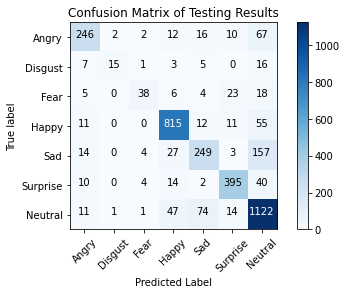

In [18]:
# Predict the values from the validation dataset
y_pred = save_model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 

# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix

plot_confusion_matrix(confusion_mtx, classes = emotions, title="Confusion Matrix of Testing Results")

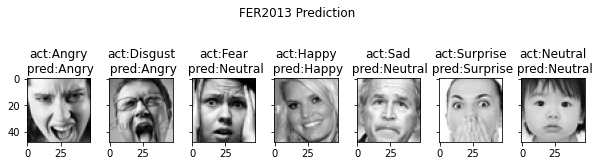

In [19]:
rands = [2082, 496, 1621, 3404, 3273, 687, 751]
# Plot
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, sharex=True,sharey=True,figsize=(10, 3))
axs=(ax1, ax2, ax3, ax4, ax5, ax6, ax7)
plt.subplots_adjust(wspace=0.3)
fig.suptitle('FER2013 Prediction')

for i, index in enumerate(rands):
  # predict
  x = np.array([X_test[index]])
  pred_x = np.argmax(save_model.predict(x))

  axs[i].imshow(X_test[index][:,:,0], cmap=plt.cm.gray)
  e_id = np.argmax(y_test[index])              
  axs[i].set_title('act:{}\n pred:{}'.format(emotions[e_id], emotions[pred_x]) )

plt.show()